In [1]:
# -------------------------
# 1) Mount Google Drive
# -------------------------
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



=== INPUT: /content/drive/MyDrive/soil_microCT_images/ROI/rehovot_ROI_8bit
Found: 661 images


Processing rehovot_ROI_8bit:   0%|          | 0/661 [00:00<?, ?it/s]

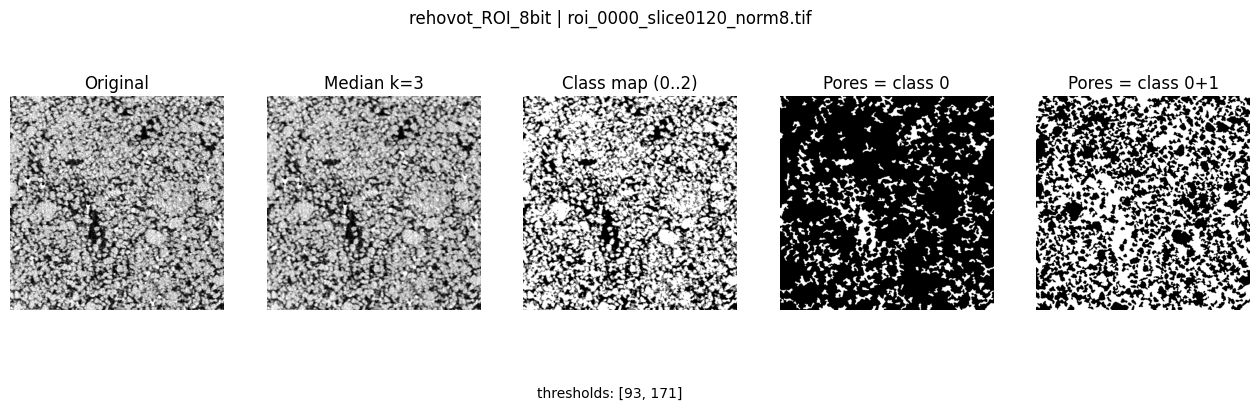

Processing rehovot_ROI_8bit:   0%|          | 1/661 [00:02<25:39,  2.33s/it]

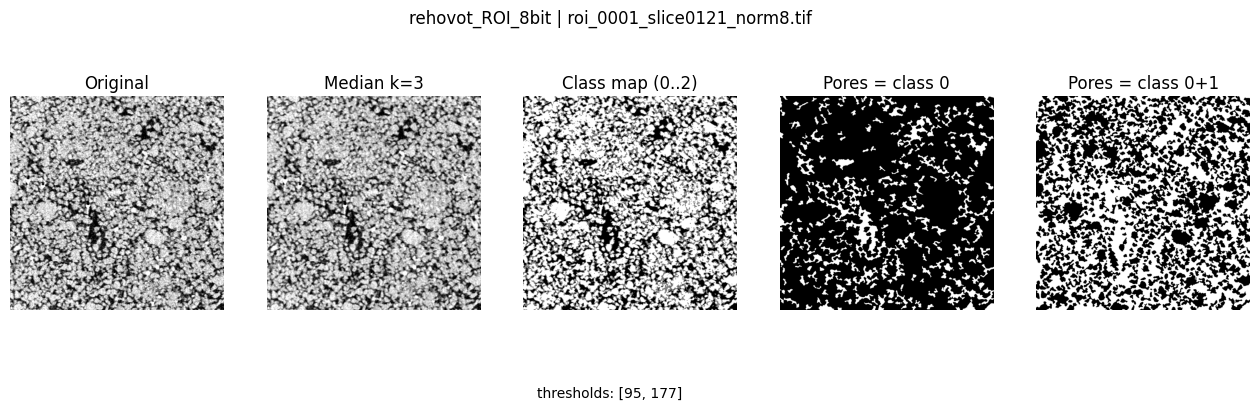

Processing rehovot_ROI_8bit:   0%|          | 2/661 [00:04<25:41,  2.34s/it]

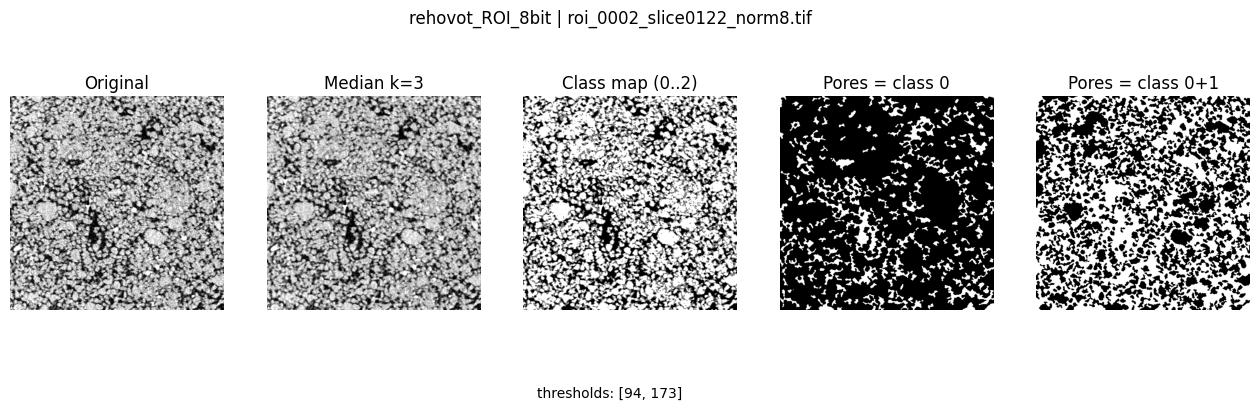

Processing rehovot_ROI_8bit:  23%|██▎       | 153/661 [01:26<02:57,  2.86it/s]

In [ ]:
# =========================
# COLAB: DARK PORES SEGMENTATION WITH MULTI-OTSU (3 INPUT FOLDERS -> 3 OUTPUT FOLDERS)
# =========================
# What it does:
# 1) Reads all images from 3 input folders on Google Drive
# 2) For each image: grayscale -> (optional) median -> Multi-Otsu (3 classes)
# 3) Saves:
#    - class map (0/1/2) as PNG
#    - pores masks for class0 only, and class0+class1 (two options)
#    - optional overlays for quick QC
# 4) Creates output folders automatically if missing

!pip -q install opencv-python-headless scikit-image matplotlib tqdm

import os
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from skimage.filters import threshold_multiotsu
from skimage.morphology import remove_small_objects, remove_small_holes


# -------------------------
# 2) CONFIG: set your 3 input folders and output root
# -------------------------
INPUT_FOLDERS = [
    "/content/drive/MyDrive/soil_microCT_images/ROI/rehovot_ROI_8bit"
]

OUTPUT_ROOT = "/content/drive/MyDrive/soil_microCT_images/drive_scripts/z_stability/data/masks"

# Median filter kernel (0 to disable). Typical: 3 or 5
MEDIAN_K = 3

# Multi-Otsu settings
N_CLASSES = 3  # 3 classes => 2 thresholds

# Cleanup parameters (pixels)
MIN_AREA_PX = 80
MAX_HOLE_AREA_PX = 80

# Optional morphology cleanup (0 to disable)
MORPH_OPEN_K = 3
MORPH_CLOSE_K = 3

# Save overlay images too?
SAVE_OVERLAY = True

# Preview how many images per folder
PREVIEW_N = 3

# File extensions to process
EXTS = {".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp"}

# -------------------------
# Helpers
# -------------------------
def ensure_dir(p: str):
    Path(p).mkdir(parents=True, exist_ok=True)

def list_images(folder: str):
    folder = Path(folder)
    files = []
    if not folder.exists():
        return files
    for f in folder.iterdir():
        if f.is_file() and f.suffix.lower() in EXTS:
            files.append(str(f))
    return sorted(files)

def apply_morph(mask_u8: np.ndarray, open_k: int, close_k: int):
    out = mask_u8.copy()
    if open_k and open_k > 1:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_k, open_k))
        out = cv2.morphologyEx(out, cv2.MORPH_OPEN, k)
    if close_k and close_k > 1:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_k, close_k))
        out = cv2.morphologyEx(out, cv2.MORPH_CLOSE, k)
    return out

def make_overlay(gray: np.ndarray, mask_u8: np.ndarray, alpha=0.35):
    # # Convert grayscale to BGR for overlay
    bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    overlay = bgr.copy()
    # # Highlight mask in red
    overlay[mask_u8 > 0] = (0, 0, 255)  # BGR
    # # Blend
    out = cv2.addWeighted(overlay, alpha, bgr, 1 - alpha, 0)
    return out

def clean_bool_mask(m: np.ndarray, min_area_px: int, max_hole_px: int):
    # # Remove tiny holes and tiny objects
    m = remove_small_holes(m, area_threshold=max_hole_px)
    m = remove_small_objects(m, min_size=min_area_px)
    return m

def show_preview(gray, filtered, classmap, pores0_u8, pores01_u8, thresholds, title):
    plt.figure(figsize=(16, 4))
    plt.suptitle(title)

    plt.subplot(1, 5, 1)
    plt.imshow(gray, cmap="gray")
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 5, 2)
    plt.imshow(filtered, cmap="gray")
    plt.title(f"Median k={MEDIAN_K}" if MEDIAN_K else "No filter")
    plt.axis("off")

    plt.subplot(1, 5, 3)
    plt.imshow(classmap, cmap="gray")
    plt.title(f"Class map (0..{N_CLASSES-1})")
    plt.axis("off")

    plt.subplot(1, 5, 4)
    plt.imshow(pores0_u8, cmap="gray")
    plt.title("Pores = class 0")
    plt.axis("off")

    plt.subplot(1, 5, 5)
    plt.imshow(pores01_u8, cmap="gray")
    plt.title("Pores = class 0+1")
    plt.axis("off")

    plt.figtext(0.5, 0.01, f"thresholds: {thresholds}", ha="center")
    plt.show()

# -------------------------
# 3) Main: process folders
# -------------------------
ensure_dir(OUTPUT_ROOT)

stats = {}

for in_dir in INPUT_FOLDERS:
    in_dir = in_dir.strip()
    folder_name = Path(in_dir).name if in_dir else "EMPTY"

    imgs = list_images(in_dir)
    print(f"\n=== INPUT: {in_dir}")
    print(f"Found: {len(imgs)} images")

    out_dir = os.path.join(OUTPUT_ROOT, folder_name)
    ensure_dir(out_dir)

    out_class_dir = os.path.join(out_dir, "classmap")
    out_mask0_dir  = os.path.join(out_dir, "pores_class0")
    out_mask01_dir = os.path.join(out_dir, "pores_class0_plus_1")
    ensure_dir(out_class_dir)
    ensure_dir(out_mask0_dir)
    ensure_dir(out_mask01_dir)

    out_overlay0_dir = os.path.join(out_dir, "overlays_class0")
    out_overlay01_dir = os.path.join(out_dir, "overlays_class0_plus_1")
    if SAVE_OVERLAY:
        ensure_dir(out_overlay0_dir)
        ensure_dir(out_overlay01_dir)

    thresholds_list = []
    preview_done = 0

    for img_path in tqdm(imgs, desc=f"Processing {folder_name}"):
        gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if gray is None:
            continue

        # 1) Optional median filtering
        if MEDIAN_K and MEDIAN_K > 1:
            filtered = cv2.medianBlur(gray, MEDIAN_K)
        else:
            filtered = gray

        # 2) Multi-Otsu thresholds
        # thresholds is an array of length N_CLASSES-1
        thresholds = threshold_multiotsu(filtered, classes=N_CLASSES)
        thresholds_list.append(tuple([float(x) for x in thresholds]))

        # 3) Digitize into classes
        # classmap values: 0..N_CLASSES-1
        classmap = np.digitize(filtered, bins=thresholds).astype(np.uint8)

        # 4) Two candidate pore masks:
        # - strict pores: class 0 (darkest)
        # - relaxed pores: class 0 or 1 (dark + mid)
        pores0 = (classmap == 0)
        pores01 = (classmap <= 1)

        # 5) Clean masks
        pores0 = clean_bool_mask(pores0, MIN_AREA_PX, MAX_HOLE_AREA_PX)
        pores01 = clean_bool_mask(pores01, MIN_AREA_PX, MAX_HOLE_AREA_PX)

        pores0_u8 = (pores0.astype(np.uint8) * 255)
        pores01_u8 = (pores01.astype(np.uint8) * 255)

        # 6) Optional morphology
        pores0_u8 = apply_morph(pores0_u8, MORPH_OPEN_K, MORPH_CLOSE_K)
        pores01_u8 = apply_morph(pores01_u8, MORPH_OPEN_K, MORPH_CLOSE_K)

        # 7) Save outputs
        base = Path(img_path).stem

        # class map as PNG (0/1/2) -> scale to 0..255 for visibility
        class_vis = (classmap * int(255/(N_CLASSES-1))).astype(np.uint8)
        cv2.imwrite(os.path.join(out_class_dir, f"{base}_classmap.png"), class_vis)

        cv2.imwrite(os.path.join(out_mask0_dir, f"{base}_pores_class0.png"), pores0_u8)
        cv2.imwrite(os.path.join(out_mask01_dir, f"{base}_pores_class0plus1.png"), pores01_u8)

        if SAVE_OVERLAY:
            ov0 = make_overlay(gray, pores0_u8, alpha=0.35)
            ov01 = make_overlay(gray, pores01_u8, alpha=0.35)
            cv2.imwrite(os.path.join(out_overlay0_dir, f"{base}_overlay_class0.png"), ov0)
            cv2.imwrite(os.path.join(out_overlay01_dir, f"{base}_overlay_class0plus1.png"), ov01)

        # 8) Preview a few
        if preview_done < PREVIEW_N:
            show_preview(
                gray, filtered, classmap, pores0_u8, pores01_u8,
                thresholds=thresholds.tolist(),
                title=f"{folder_name} | {Path(img_path).name}"
            )
            preview_done += 1

    # Stats per folder
    if thresholds_list:
        # Flatten thresholds stats
        arr = np.array(thresholds_list, dtype=float)  # shape: (n, N_CLASSES-1)
        stats[folder_name] = {
            "n": int(arr.shape[0]),
            "t1_mean": float(arr[:, 0].mean()),
            "t1_std": float(arr[:, 0].std()),
            "t2_mean": float(arr[:, 1].mean()) if arr.shape[1] > 1 else None,
            "t2_std": float(arr[:, 1].std()) if arr.shape[1] > 1 else None,
        }

print("\n=== MULTI-OTSU THRESHOLD STATS (per folder) ===")
for k, v in stats.items():
    print(k, v)

print("\nDone ✅ Output root:", OUTPUT_ROOT)
